In [1]:
import numpy as np
import MGrowth as mg
import time
import matplotlib.pyplot as plt
from scipy.integrate import odeint, quad
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from matplotlib import rc
rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Times']})
import seaborn as sns
palette = sns.color_palette('Dark2') 
colors = palette  
SMALL_SIZE = 14
MEDIUM_SIZE = 22
BIGGER_SIZE = 28
VERY_SMALL= 14
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('font', size=SMALL_SIZE)
plt.rc('legend', fontsize=VERY_SMALL)

# Test $w$-interpolator with CPL 
In this notebook we an demonstrate example of using $w(a)$-interpolators. We take a CPL cosmology with $\Omega_{\rm m}=0.3$ and $w(a)=w_0+w_a(1-a)$ and test our implementation of the $w(a)$-interpolator.

In [2]:
def Omega_m(a, omega0, w_interp):
    integrand_w = lambda a_in: 3.*(1.+w_interp(a_in))/a_in
    omegaL = (1.-omega0) * np.exp(quad(integrand_w, a, 1.)[0])
    E2 = omega0/a**3 + omegaL
    return omega0/a**3/E2

def dlnH_dlna_DE(a, omega0, w_interp):
    integrand_w = lambda a_in: 3.*(1.+w_interp(a_in))/a_in
    omegaL = (1.-omega0) * np.exp(quad( integrand_w, a, 1.)[0])
    E2 = omega0/a**3 + omegaL
    return  -1.5 * (omega0/a**3 + (1+w_interp(a))*omegaL)/E2    


def DE_D_derivatives(D, a, w_interp, omega0):
    return [D[1], -D[1]/a*(3.+dlnH_dlna_DE(a, omega0, w_interp))+1.5*D[0]/a**2*Omega_m(a, omega0, w_interp)]

In [3]:
a_start = 1.e-4
a_arr = np.linspace(1e-3, 1, 512)
aa = np.hstack(([a_start], a_arr))
omega0 = 0.3
w0 = -0.4
wa = -1.7

CPL = w0+wa*(1.-a_arr)
w_interpolator = interp1d(a_arr, CPL, bounds_error=False,
                kind='cubic',
                fill_value=(CPL[0], CPL[-1])) 

In [4]:
start = time.time()
D, dDda = odeint(DE_D_derivatives, [a_start, 1.], aa, args=(w_interpolator, omega0)).T  
f = aa*dDda/D
finish = time.time()
Da, fa = D[1:], f[1:] 
print('Interpolator time: ', finish-start)

Interpolator time:  0.15811610221862793


In [5]:
background ={'Omega_m': omega0,
            'h' : 0.68,
            'w0': w0,
            'wa': wa,
            'a_arr': a_arr}
cosmo = mg.w0waCDM(background)
start = time.time()
D_cpl, f_cpl = cosmo.growth_parameters()
finish = time.time()
print('CPL time: ', finish-start)

CPL time:  0.0010650157928466797


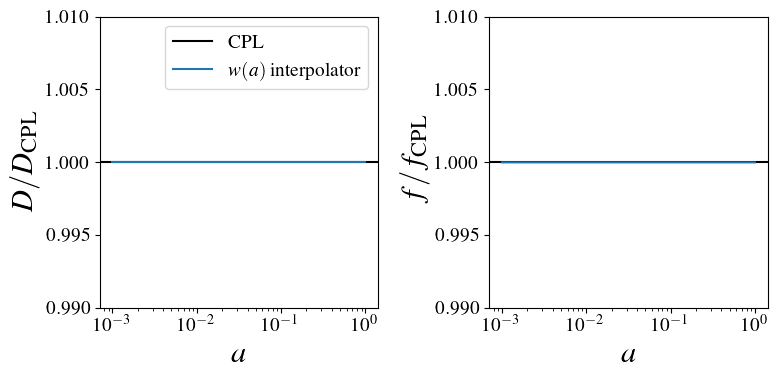

In [6]:
fig, ax = plt.subplots(figsize=(8, 4), ncols=2, facecolor='w')
ax[0].axhline(y=1, color='k', label='CPL')
ax[1].axhline(y=1, color='k')
ax[0].semilogx(a_arr, Da/D_cpl, label='$w(a)$ interpolator')
ax[1].semilogx(a_arr, fa/f_cpl)
ax[0].set_xlabel('$a$')
ax[1].set_xlabel('$a$')
ax[0].set_ylabel('$D/D_{\\rm CPL}$')
ax[1].set_ylabel('$f/f_{\\rm CPL}$')
ax[0].legend(loc='upper right', title_fontsize=16)
ax[0].set_ylim(0.99, 1.01)
ax[1].set_ylim(0.99, 1.01)
plt.tight_layout()
plt.show()

# JAX
Let's try JAX to speedup the calculation with $w(a)$-interpolator.

In [7]:
import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint
import time
from jax import jit

In [8]:
@jit
def interp1d_jax(x, xp, fp):
    indices = jnp.clip(jnp.searchsorted(xp, x) - 1, 0, len(xp) - 2)
    x0 = xp[indices]
    x1 = xp[indices + 1]
    y0 = fp[indices]
    y1 = fp[indices + 1]
    return y0 + (y1 - y0) * (x - x0) / (x1 - x0)

@jit
def trapz_jax(y, x):
    dx = x[1:] - x[:-1]
    return jnp.sum(0.5 * dx * (y[1:] + y[:-1]))

@jit
def Omega_m(a, omega0, a_grid, w_vals):
    def integrand(a_in):
        w = interp1d_jax(a_in, a_grid, w_vals)
        return 3. * (1. + w) / a_in
    
    a_eval = jnp.linspace(a, 1.0, 256)
    w_integrand = integrand(a_eval)
    integral = trapz_jax(w_integrand, a_eval)
    
    omegaL = (1. - omega0) * jnp.exp(integral)
    E2 = omega0 / a**3 + omegaL
    return omega0 / a**3 / E2

@jit
def dlnH_dlna_DE(a, omega0, a_grid, w_vals):
    def integrand(a_in):
        w = interp1d_jax(a_in, a_grid, w_vals)
        return 3. * (1. + w) / a_in
    
    a_eval = jnp.linspace(a, 1.0, 256)
    w_integrand = integrand(a_eval)
    integral = trapz_jax(w_integrand, a_eval)

    omegaL = (1. - omega0) * jnp.exp(integral)
    E2 = omega0 / a**3 + omegaL
    w_a = interp1d_jax(a, a_grid, w_vals)
    return -1.5 * (omega0 / a**3 + (1 + w_a) * omegaL) / E2

@jit
def DE_D_derivatives(D, a, a_grid, w_vals, omega0):
    D1, D2 = D
    dlnH = dlnH_dlna_DE(a, omega0, a_grid, w_vals)
    Om = Omega_m(a, omega0, a_grid, w_vals)
    dD1 = D2
    dD2 = -D2 / a * (3. + dlnH) + 1.5 * D1 / a**2 * Om
    return jnp.array([dD1, dD2])

In [9]:
a_start = 1e-4
a_arr = jnp.linspace(1e-3, 1.0, 512)
aa = jnp.concatenate([jnp.array([a_start]), a_arr])
omega0 = 0.3
w0, wa = -0.4, -1.7
CPL = w0 + wa * (1. - a_arr)

# Interpolated w(a) table (for use in JAX interpolation)
a_grid = a_arr
w_vals = CPL



start = time.time()
D_sol = odeint(DE_D_derivatives, jnp.array([a_start, 1.0]), aa, a_grid, w_vals, omega0)
D, dDda = D_sol.T
f = aa * dDda / D
finish = time.time()


Da, fa = D[1:], f[1:]

print('Interpolator time: ', finish - start)

Interpolator time:  0.34557604789733887


In [10]:
start = time.time()
D_sol = odeint(DE_D_derivatives, jnp.array([a_start, 1.0]), aa, a_grid, w_vals, omega0)
D, dDda = D_sol.T
f = aa * dDda / D
finish = time.time()

Da, fa = D[1:], f[1:]

print('Interpolator time (second call): ', finish - start)

Interpolator time (second call):  0.0019121170043945312


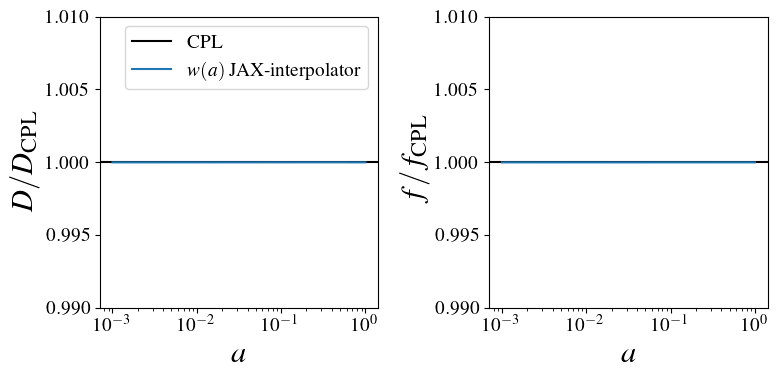

In [11]:
fig, ax = plt.subplots(figsize=(8, 4), ncols=2, facecolor='w')
ax[0].axhline(y=1, color='k', label='CPL')
ax[1].axhline(y=1, color='k')
ax[0].semilogx(a_arr, Da/D_cpl, label='$w(a)$ JAX-interpolator')
ax[1].semilogx(a_arr, fa/f_cpl)
ax[0].set_xlabel('$a$')
ax[1].set_xlabel('$a$')
ax[0].set_ylabel('$D/D_{\\rm CPL}$')
ax[1].set_ylabel('$f/f_{\\rm CPL}$')
ax[0].legend(loc='upper right', title_fontsize=16)
ax[0].set_ylim(0.99, 1.01)
ax[1].set_ylim(0.99, 1.01)
plt.tight_layout()
plt.show()